In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [29]:
# Load data
app = pd.read_csv('appstore_games.csv')

In [30]:
app.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17007 entries, 0 to 17006
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   URL                           17007 non-null  object 
 1   ID                            17007 non-null  int64  
 2   Name                          17007 non-null  object 
 3   Subtitle                      5261 non-null   object 
 4   Icon URL                      17007 non-null  object 
 5   Average User Rating           7561 non-null   float64
 6   User Rating Count             7561 non-null   float64
 7   Price                         16983 non-null  float64
 8   In-app Purchases              7683 non-null   object 
 9   Description                   17007 non-null  object 
 10  Developer                     17007 non-null  object 
 11  Age Rating                    17007 non-null  object 
 12  Languages                     16947 non-null  object 
 13  S

In [31]:
app_c1 = app.copy()
app_c1 = app_c1.drop(columns=['URL','Icon URL','Description','Subtitle','In-app Purchases'])


In [32]:
print(f'Duplicates: {app_c1.duplicated().sum()}')
app_c1.drop_duplicates(inplace=True)
print(f'Shape after deduplication: {app_c1.shape}')

Duplicates: 160
Shape after deduplication: (16847, 13)


In [33]:
# Handle missing values
missing_pct = np.round((app_c1.isnull().sum()/app.shape[0])*100,2)
print(missing_pct)

ID                               0.00
Name                             0.00
Average User Rating             55.03
User Rating Count               55.03
Price                            0.14
Developer                        0.00
Age Rating                       0.00
Languages                        0.35
Size                             0.01
Primary Genre                    0.00
Genres                           0.00
Original Release Date            0.00
Current Version Release Date     0.00
dtype: float64


In [34]:
app_c1.columns = [c.replace(" ", "_") for c in app_c1.columns]
app_c1['Age_Rating'] = app_c1['Age_Rating'].str.replace("+","").astype('int')
app_c1['Original_Release_Date'] = pd.to_datetime(app_c1['Original_Release_Date'], format='%d/%m/%Y')
app_c1['Current_Version_Release_Date'] = pd.to_datetime(app_c1['Current_Version_Release_Date'], format='%d/%m/%Y')


/tmp/ipykernel_8213/3153772833.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  app_c1['Age_Rating'] = app_c1['Age_Rating'].str.replace("+","").astype('int')


In [35]:
df = app_c1

In [36]:
# Fill missing 'Average_User_Rating' with median
median_ratings = df.groupby('Primary_Genre')['Average_User_Rating'].median()
df['Average_User_Rating'] = df.apply(
    lambda row: median_ratings[row['Primary_Genre']] if pd.isnull(row['Average_User_Rating']) else row['Average_User_Rating'],
    axis=1
)

In [37]:
# Fill missing 'User_Rating_Count' with median
median_ratings_user = df.groupby('Primary_Genre')['User_Rating_Count'].median()
df['User_Rating_Count'] = df.apply(
    lambda row: median_ratings_user[row['Primary_Genre']] if pd.isnull(row['User_Rating_Count']) else row['User_Rating_Count'],
    axis=1
)

In [38]:
# Fill missing 'Price' with median
median_ratings_user = df.groupby('Primary_Genre')['Price'].median()
df['Price'] = df.apply(
    lambda row: median_ratings_user[row['Primary_Genre']] if pd.isnull(row['Price']) else row['Price'],
    axis=1
)

In [39]:
# Fill missing 'Languages' with 'Unknown'
df['Languages'].fillna('Unknown', inplace=True)

In [40]:
df['Language_Count'] = df['Languages'].str.split(', ').apply(len)
df.drop(columns=['Languages'], inplace=True)

In [41]:
df['Size'] = df['Size'].fillna(df['Size'].median())

In [42]:
df['Name'] = df['Name'].str.replace(r'[^A-Za-z0-9 ]+', '', regex=True)
df['Name'] = df['Name'].str[:60]
df['Developer'] =df['Developer'].str.replace(r'[^A-Za-z0-9 ]+', '', regex=True)
df['Developer'] = df['Developer'].str[:30]

In [43]:
# Remove "Games" and limit to the first 3 genres
df['Genres'] = df['Genres'].str.replace("Games, ", "")
df['Genres'] = df['Genres'].str.split(', ').apply(lambda x: ', '.join(x[:3]))


Exploratory Data Analysis



/tmp/ipykernel_8213/3808707765.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Average_User_Rating', palette='gray', alpha=0.7, linewidth=4, edgecolor='black')


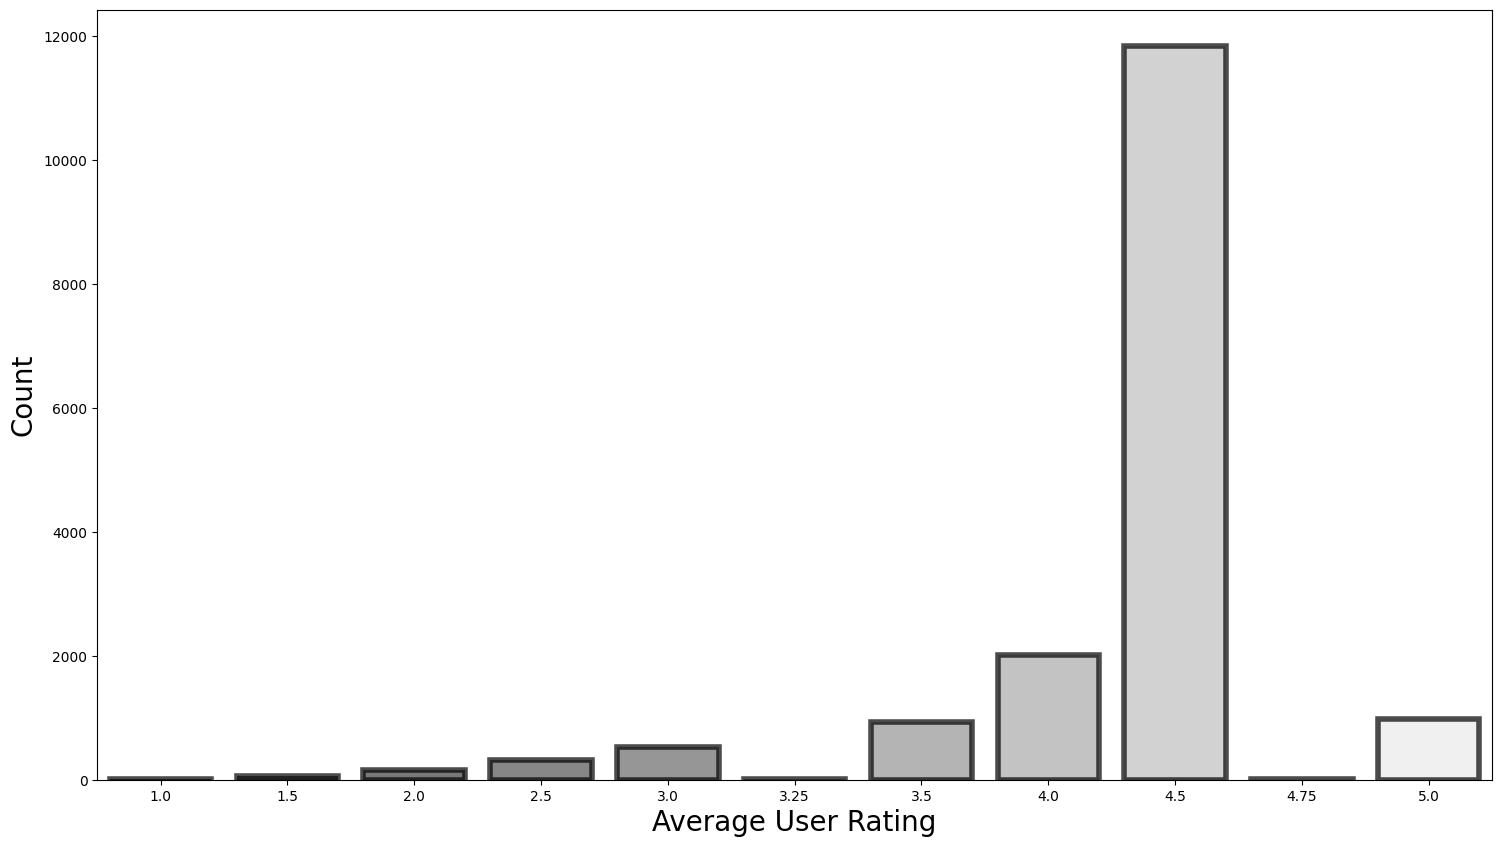

In [44]:
plt.rcParams['figure.figsize'] = (18, 10)
ax = sns.countplot(data=df, x='Average_User_Rating', palette='gray', alpha=0.7, linewidth=4, edgecolor='black')
ax.set_ylabel('Count', fontsize=20)
ax.set_xlabel('Average User Rating', fontsize=20)
plt.show()

/tmp/ipykernel_8213/3317729952.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(df['Size2'], shade=True, linewidth=5, color='teal')


Text(0.5, 0, 'Size (MB)')

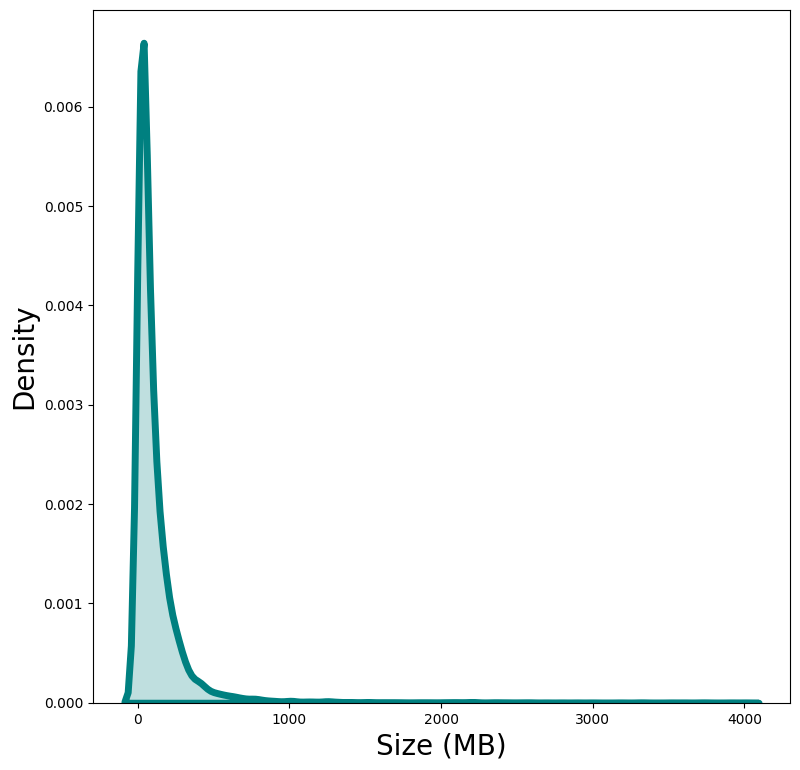

In [45]:
df['Size2'] = round(df['Size'] / 1000000, 1)

# Plotting the Kernel Density Estimate (KDE)
plt.rcParams['figure.figsize'] = (9, 9)
ax = sns.kdeplot(df['Size2'], shade=True, linewidth=5, color='teal')

# Set labels for axes
ax.set_ylabel('Density', fontsize=20)
ax.set_xlabel('Size (MB)', fontsize=20)

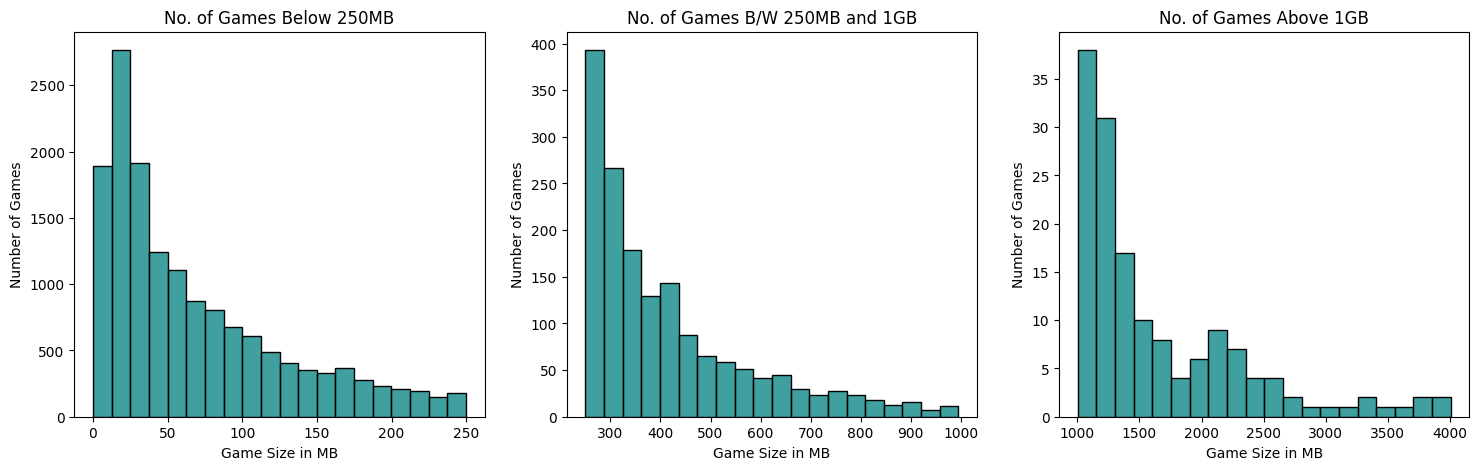

In [46]:
# Create subplots for three distributions
f, axes = plt.subplots(1, 3, figsize=(18, 5))

Size_Less_250MB = df[df.Size2 <250]
Size_More_250MB = df[(df.Size2 >=250) & (df.Size2 <1000)]
Size_More_1GB = df[df.Size2 >=1000]


# Plot the histograms using sns.histplot
sns.histplot(Size_Less_250MB.Size2, bins=20, kde=False, ax=axes[0], color='teal')
sns.histplot(Size_More_250MB.Size2, bins=20, kde=False, ax=axes[1], color='teal')
sns.histplot(Size_More_1GB.Size2, bins=20, kde=False, ax=axes[2], color='teal')

# Set axis labels and titles for each subplot
for ax in axes:
    ax.set(xlabel='Game Size in MB', ylabel='Number of Games')

# Set individual titles for each subplot
axes[0].set_title('No. of Games Below 250MB')
axes[1].set_title('No. of Games B/W 250MB and 1GB')
axes[2].set_title('No. of Games Above 1GB')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Show the plot
plt.show()

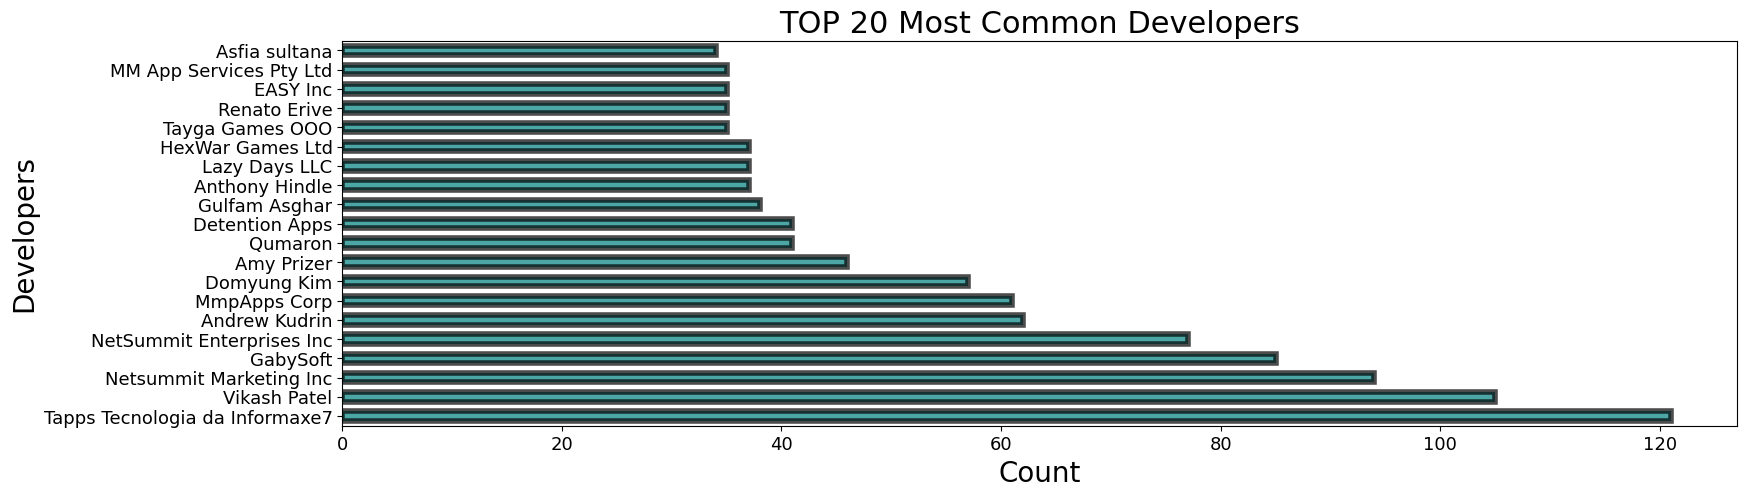

In [47]:
plt.rcParams['figure.figsize'] = (18, 5)

# Get top 20 most common developers and sort by count
top_developers = df.Developer.value_counts().head(20)

# Plot a horizontal bar chart
top_developers.plot(kind='barh', color='teal', alpha=0.7, linewidth=4, edgecolor='black')

# Set labels and title
plt.xlabel("Count", fontsize=20)
plt.ylabel("Developers", fontsize=20)
plt.title("TOP 20 Most Common Developers", fontsize=22)

# Adjust font size for tick labels
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Show the plot
plt.show()

In [48]:
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot

def pie_plot(cnt_srs, colors, title):
    labels = cnt_srs.index
    values = cnt_srs.values
    
    # Create a dynamic color palette using Plotly Express
    color_palette = px.colors.qualitative.Set3  # Set3 offers a good variety of colors
    
    # Plotting the pie chart with more detailed customization
    trace = go.Pie(labels=labels, 
                   values=values, 
                   title=title, 
                   hoverinfo='label+percent+value',  # Display both label, percentage, and value
                   textinfo='label+percent',  # Show label and percentage on the chart
                   textposition='inside',  # Position text inside the slices
                   hole=0.3,  # Adding a hole to create a donut chart effect
                   showlegend=True,
                   marker=dict(colors=color_palette[:len(labels)],  # Ensure the color palette matches the number of slices
                               line=dict(color='#000000', width=2),  # Black border around each slice
                              )
                  )
    return trace

# Call the function with the Age Rating data
trace = pie_plot(df['Age_Rating'].value_counts(), px.colors.qualitative.Set3, 'Age Rating')

# Show the plot
iplot([trace])


/tmp/ipykernel_8213/1684981354.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




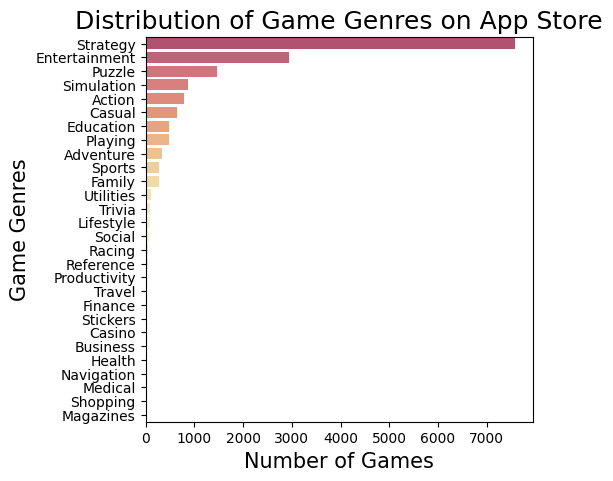

In [49]:
# Extract genres list and calculate counts
df['Genreslist'] = df['Genres'].str.extract('([A-Z]\w{5,})', expand=True)
genre_counts = df['Genreslist'].value_counts()

# Create a horizontal bar chart
plt.figure(figsize=(5, 5), dpi=100)
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='Spectral', alpha=0.8)

# Adding labels and title
plt.xlabel('Number of Games', fontsize=15)
plt.ylabel('Game Genres', fontsize=15)
plt.title('Distribution of Game Genres on App Store', fontsize=18)

# Show plot
plt.show()

# Probability Distribution of Data

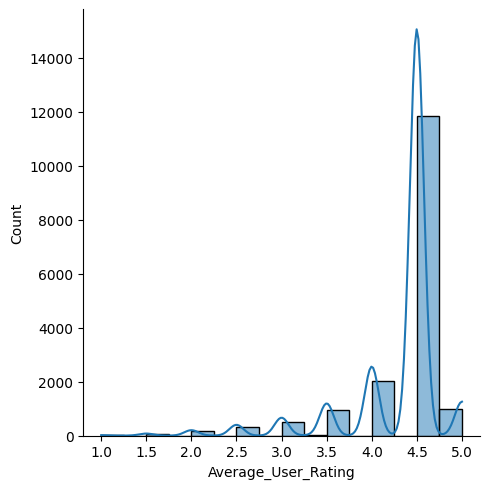

In [50]:
sns.displot(df.Average_User_Rating, kde = True)

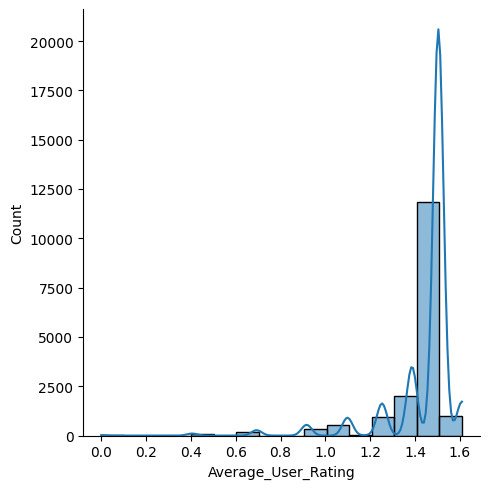

In [51]:
sns.displot(np.log(df.Average_User_Rating), kde = True)
#We have done variaous transformations on the columns, but we cannot see much big difference in the distribution of the data. 
#So, we are keeping the original variable without any transformation.

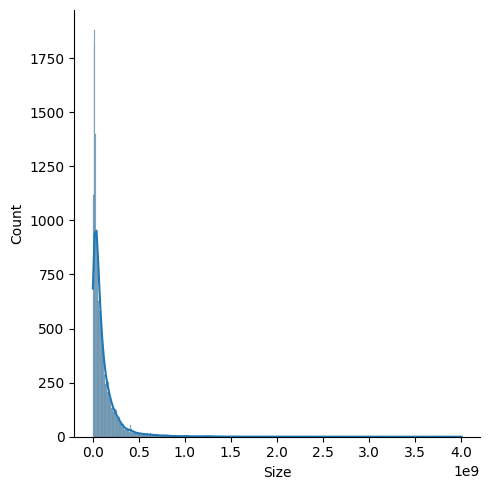

In [52]:
sns.displot(df.Size, kde = True)

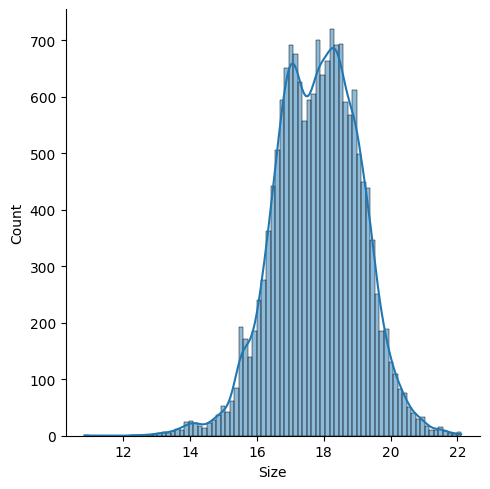

In [53]:
sns.displot(np.log(df.Size), kde = True)

In [54]:
df['Log_Size'] = np.log(df['Size'])

In [55]:
df_new = df.drop(columns = 'Size')

# One-hot Encoding for categorical data

In [56]:
df_new.select_dtypes(include = 'object')

,Name,Developer,Primary_Genre,Genres,Genreslist
0,Sudoku,Mighty Mighty Good Games,Games,"Strategy, Puzzle",Strategy
1,Reversi,Kiss The Machine,Games,"Strategy, Board",Strategy
2,Morocco,Bayou Games,Games,"Board, Strategy",Strategy
3,Sudoku Free,Mighty Mighty Good Games,Games,"Strategy, Puzzle",Strategy
4,Senet Deluxe,RoGame Software,Games,"Strategy, Board, Education",Strategy
...,...,...,...,...,...
17002,Stack Puzzle Rise Tower,Zhigang Pei,Games,"Entertainment, Casual, Strategy",Entertainment
17003,EachOther,Sultan Shindi,Games,"Family, Strategy",Family
17004,Rabbit Vs Tortoise,Vishal Baldha,Games,Strategy,Strategy
17005,FaTaLL,Tayrem Games,Games,"Strategy, Action",Strategy


In [57]:
df_new.Genres.nunique()

787

In [58]:
df_new = df_new.drop(columns = ['Name','Developer','Genres','Genreslist'])

In [59]:
df_new = pd.get_dummies(df_new, columns = ['Primary_Genre'], dtype = int)

In [60]:
df_new = df_new.drop(columns = ['Original_Release_Date','Current_Version_Release_Date'])

In [61]:
df_new.head()

,ID,Average_User_Rating,User_Rating_Count,Price,Age_Rating,Language_Count,Size2,Log_Size,Primary_Genre_Book,Primary_Genre_Business,...,Primary_Genre_Navigation,Primary_Genre_News,Primary_Genre_Productivity,Primary_Genre_Reference,Primary_Genre_Shopping,Primary_Genre_Social Networking,Primary_Genre_Sports,Primary_Genre_Stickers,Primary_Genre_Travel,Primary_Genre_Utilities
0,284921427,4.0,3553.0,2.99,4,17,15.9,16.578905,0,0,...,0,0,0,0,0,0,0,0,0,0
1,284926400,3.5,284.0,1.99,4,1,12.3,16.327462,0,0,...,0,0,0,0,0,0,0,0,0,0
2,284946595,3.0,8376.0,0.00,4,1,0.7,13.422195,0,0,...,0,0,0,0,0,0,0,0,0,0
3,285755462,3.5,190394.0,0.00,4,17,21.6,16.885985,0,0,...,0,0,0,0,0,0,0,0,0,0
4,285831220,3.5,28.0,2.99,4,15,34.7,17.361934,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

# Define features (X) and target (y)
X = df_new.drop(columns=['Average_User_Rating'])
y = df_new['Average_User_Rating']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Dictionary to store model performance
model_performance = {}

# List of models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Support Vector Machine": SVR(),
    "k-Nearest Neighbors": KNeighborsRegressor()
}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    model_performance[model_name] = rmse
    print(f"{model_name} RMSE: {rmse:.3f}")

print("\nModel performance:", model_performance)

Linear Regression RMSE: 0.512
Decision Tree RMSE: 0.645
Random Forest RMSE: 0.480
Support Vector Machine RMSE: 0.520
k-Nearest Neighbors RMSE: 0.552

Model performance: {'Linear Regression': 0.5121470140338569, 'Decision Tree': 0.6446442980580789, 'Random Forest': 0.4796019113008644, 'Support Vector Machine': 0.5200517999605497, 'k-Nearest Neighbors': 0.5523692338682825}
